# Paso 5 - Inferencia unificada (dataset + scoring)

**Flujo**: A partir de `data/interim/` se crea el dataset wide de inferencia para la fecha de corte `CUTOFF`, se aplica preprocesamiento, se cargan modelo y features desde **models/**, se obtienen scores P(fraud) y se guarda CSV en **data/predictions/**.

- **Input**: `data/interim/` (parquets), `models/lgbm_model.pkl`, `models/features.pkl`.
- **Output**: `data/processed/inference/cutoff=<CUTOFF>/inference_wide.parquet` (generado aquí) y `data/predictions/scores_<CUTOFF>.csv`.

---
## 1. Imports y path del proyecto

Se agrega la raíz del proyecto a `sys.path` y se importan las funciones de creación de dataset.

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import joblib
import warnings

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.config import load_config, get_paths
from src.data.make_dataset import get_date_range_for_cutoff, create_inference_dataset
from src.preprocessing.preprocessing import preprocess_model_input

%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

---
## 2. Configuración

Se carga desde **config/config.yaml**. Editar allí la fecha de corte (inference.cutoff); las notebooks y scripts usan la misma config.

**CUTOFF**: mes que se quiere predecir; ese mes no entra en el análisis (solo se usa consumo anterior a CUTOFF).

In [4]:
cfg = load_config()
paths = get_paths(cfg)
INTERIM_DIR = paths["interim"]
PROCESSED_DIR = paths["processed"]
MODELS_DIR = paths["models"]
PREDICTIONS_DIR = paths["predictions"]

inf = cfg["inference"]
CUTOFF = inf["cutoff"]
CANT_PERIODOS = inf["cant_periodos"]
CONTRATOS_LIST = inf["contratos_list"]
COLUMNS_FILTER = inf.get("columns_filter")

START_LOAD, END_LOAD = get_date_range_for_cutoff(CUTOFF, CANT_PERIODOS)
print(f"Rango a cargar desde interim: {START_LOAD.strftime('%Y-%m-%d')} a {END_LOAD.strftime('%Y-%m-%d')} ({CANT_PERIODOS + 1} meses)")

Rango a cargar desde interim: 2024-09-01 a 2025-09-01 (13 meses)


---
## 3. Crear dataset de inferencia

Se construye el dataset wide a partir de interim (misma lógica que `2_dataset_creation.ipynb` en modo inference). El parquet se guarda en `data/processed/inference/cutoff=<CUTOFF>/` y se usa el dataframe en memoria para el scoring.

In [ ]:
%%time
df = create_inference_dataset(
    INTERIM_DIR, PROCESSED_DIR,
    cutoff=CUTOFF,
    cant_periodos=CANT_PERIODOS,
    contratos_list=CONTRATOS_LIST,
    columns_filter=COLUMNS_FILTER,
)
if df is None:
    raise RuntimeError("No se pudo crear el dataset de inferencia.")

print(f"Inferencia: {len(df)} filas")

In [5]:
inference_path = os.path.join(
    PROCESSED_DIR,
    "inference",
    f"cutoff={pd.to_datetime(CUTOFF).strftime('%Y-%m-%d')}",
    "inference_wide.parquet",
)
df = pd.read_parquet(inference_path)

print(f"Inferencia: {len(df)} filas")

Inferencia: 34728 filas


---
## 4. Cargar modelo y features

Se cargan el modelo y la lista de columnas desde **models/**.

In [6]:
model = joblib.load(os.path.join(MODELS_DIR, "lgbm_model.pkl"))
cols_for_model = joblib.load(os.path.join(MODELS_DIR, "features.pkl"))
print(f"Modelo y {len(cols_for_model)} features cargados.")

Modelo y 52 features cargados.


---
## 5. Validar columnas y scoring

Se comprueba que existan todas las columnas de **cols_for_model** y se obtienen los scores P(fraud).

In [7]:
# Preprocesamiento (reusable, mismo criterio que train)
df = preprocess_model_input(df)

In [8]:
missing = [c for c in cols_for_model if c not in df.columns]
if missing:
    raise ValueError(f"Columnas faltantes en inference_wide: {missing}")

scores = model.predict_proba(df[cols_for_model])[:, 1]
df_out = df[["contrato"]].copy()
df_out["score"] = scores
print(f"Scores calculados: {len(df_out)} registros")

Scores calculados: 34728 registros


---
## 6. Guardar CSV en data/predictions

Se guarda el resultado en **data/predictions/** con nombre `scores_<CUTOFF>.csv`.

In [16]:
os.makedirs(PREDICTIONS_DIR, exist_ok=True)
out_path = os.path.join(PREDICTIONS_DIR, f"scores_{CUTOFF}.csv")
df_out.to_csv(out_path, index=False)
print(f"[OK] Guardado: {out_path}")

[OK] Guardado: d:\2024\BID\Aguas\Empresa-EPM\proyecto\ar-epm_poc\data/predictions\scores_2025-06-01.csv


---
## 7. Distribución del score (opcional)

Histograma del score en el conjunto de inferencia.

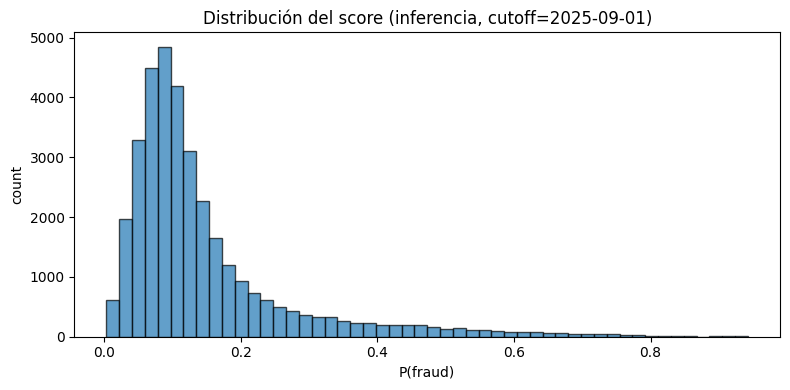

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(df_out["score"], bins=50, edgecolor="black", alpha=0.7)
plt.title(f"Distribución del score (inferencia, cutoff={CUTOFF})")
plt.xlabel("P(fraud)")
plt.ylabel("count")
plt.tight_layout()
plt.show()